In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets

import numpy as np
import torchvision
from torchvision import models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Загружаем данные

In [2]:
transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train = datasets.MNIST('../data/MNIST/train', train=True, download=True, transform=transform_list)
test = datasets.MNIST('../data/MNIST/test', train=False, download=True, transform=transform_list)
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

Extracting ../data/MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/train/MNIST/raw


Extracting ../data/MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/train/MNIST/raw


Extracting ../data/MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/train/MNIST/raw


Extracting ../data/MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/train/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../data/MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/test/MNIST/raw


Extracting ../data/MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/test/MNIST/raw


Extracting ../data/MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/test/MNIST/raw


Extracting ../data/MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/test/MNIST/raw
Processing...
Done!


In [3]:
batch, label = next(iter(trainset))

In [4]:
batch.shape

torch.Size([128, 1, 28, 28])

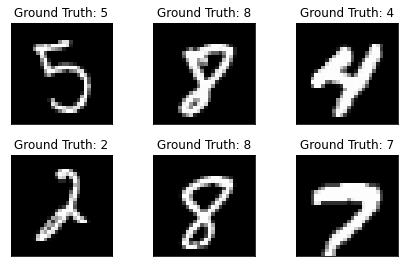

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(batch[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])


# Создаем сеть

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [7]:
network = Net()
optimizer = optim.Adagrad(network.parameters(), lr=0.01)

# Обучаем сеть

In [8]:
n_epochs = 15
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainset.dataset) for i in range(n_epochs + 1)]

In [9]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainset):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainset.dataset),
        100. * batch_idx / len(trainset), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainset.dataset)))

In [10]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testset:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction="sum").item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testset.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testset.dataset),
    100. * correct / len(testset.dataset)))

In [11]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: -0.1006, Accuracy: 1046/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.098159
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.723313
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.832805
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.869263
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.842043

Test set: Avg. loss: -0.9352, Accuracy: 9389/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.861712
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.852494
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.868279
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.913072
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.918126

Test set: Avg. loss: -0.9490, Accuracy: 9508/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.930894
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.909518
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.875245
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.928202
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.895322

Test set: Avg. loss: -0.9545, Accuracy: 9562/10000 (96%)

Train Epoch: 4

In [14]:
torch.save(network.state_dict(), "network.pt")

# Визуализируем, что видит сетка

In [15]:
network.modules

<bound method Module.modules of Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>

In [16]:
from google.colab import files
files.upload()

Saving one.png to one.png


{'one.png': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x02\x00\x00\x00\xff\x80\x02\x03\x00\x00\x00\tpHYs\x00\x00\x0b\x13\x00\x00\x0b\x13\x01\x00\x9a\x9c\x18\x00\x00\x00\x07tIME\x07\xe4\x05\x1c\x05\x0429^\xc2\x0c\x00\x00\x00\x1diTXtComment\x00\x00\x00\x00\x00Created with GIMPd.e\x07\x00\x00\x01\xcbIDATx\xda\xed\xdd\xcbn\x03!\x0c\x85\xe1b\xf1\xfe\xafL\x17]&\x95\x80a\xf0\xb1\xfd\xb3\x8c\xdaH\xf3\xe5\x98rm\xda\x18\xe3\x876\xd7\x0c\x02\xb0\xc0\x02\x0b,\xb0\xca\xb7\x9e\xfb\xf1Zk__\xdf\x1b0\xb5\xac\xe3\xac\xff\x98\x9e\x90%\xc4\x9aa\xda\xf3\xb2\xcaR\xab?o\x95\xa5V\x7f\xcb\x8aK\x95\xeb\xb3\x8e0\xcd8\x18R%\xc6Y7\x99b'\xeb\xbeT\xc8d\xb90\xc5\xc3rd\x8a\x84\xe5\xce\x14\x00K\xc4H\x1dK\x8dI\x14K\x93I\x0eK\x99Ik\x9c\xe5+59\xe7\xeb\x04*F\x19\x8a0\xcd/%t\xd2$\xddgII-\xadPu\x02%\x87\xa5\xc9\xb4\xba\xf0iH\xa9$+z\xdd]\xc2\x12g\xda\xdby0\x02\xe5\x89\xa5/\xb5\xbd\xa1eH\xf9`e\xad>\xb9U\x07\xfdX\x9d\xc4\xba\x10+\xf7\xcds+\x12\x8aH\xd3\x1d\x05\xa6\xe7\xef\xd3ISx\xac\xe3LG\xde\xd0\x08T\x

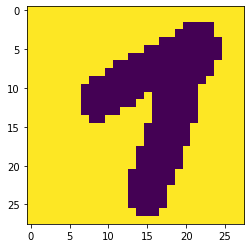

In [19]:
from tensorflow.python.keras.preprocessing import image
image_file_name = 'one.png'
img = image.load_img(image_file_name, target_size=(28, 28), color_mode="grayscale")
plt.imshow(img)

# Запускаем изображение в обрезанную модель

In [17]:
network.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [20]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.
img_array = torch.from_numpy(img_array)

In [21]:
img_array = img_array.reshape(-1, 1, 28, 28)
img_array.shape


torch.Size([1, 1, 28, 28])

(10, 24, 24)
1.0


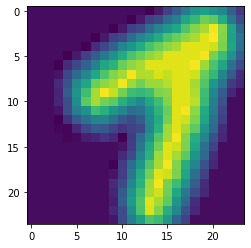

In [22]:
activation = network.conv1(img_array)
activation = activation.detach().numpy()
activation = activation.reshape(-1, 24, 24)
print(activation.shape)
print(len(activation)/10)
plt.imshow(activation[0]/2+.5)


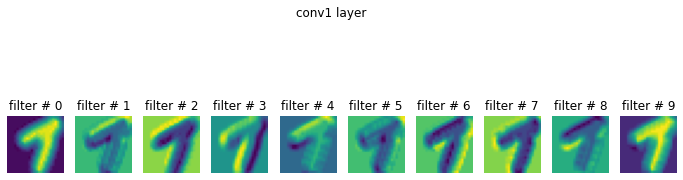

In [23]:
f = plt.figure(figsize=(12, 4))
f.suptitle('conv1 layer')
for i in range(10):
    f.add_subplot(np.ceil(len(activation)/10), 10, i+1)
    plt.imshow(activation[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)

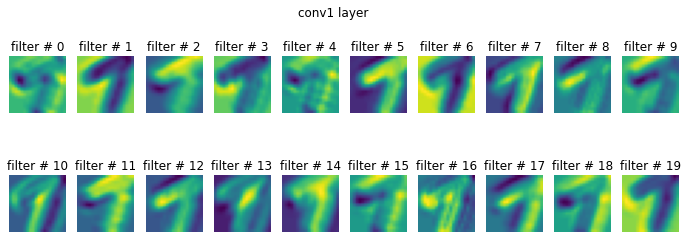

In [24]:
activation = network.conv2(network.conv1(img_array))
activation = activation.detach().numpy()
activation = activation.reshape(-1, 20, 20)
f = plt.figure(figsize=(12, 4))
f.suptitle('conv1 layer')
for i in range(20):
    f.add_subplot(np.ceil(len(activation)/10), 10, i+1)
    plt.imshow(activation[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Создаем обучаемый тензор со случайными числами и с размерностью картинки 1 на 28 на 28

In [26]:
image = torch.randn((1,28,28))*0.001
image = image.to(device)
image.requires_grad = True

In [27]:
plt.imshow(image.detach().numpy().reshape(28, 28))

TypeError: ignored

In [109]:
# быстрая проверка что сейчас выдаёт модель на картинку
model.to(device)
image.to(device)

output = network(image.unsqueeze(0))
print(output)
print(torch.argmax(output))
target = get_target(4)
print((target-output)*(target-output).sum())
r = (target-output)*(target-output).sum()
torch.sum(r)

tensor([[-2.2880, -1.9464, -2.3487, -2.4380, -2.3279, -2.4815, -2.4258, -2.3876,
         -2.2017, -2.2933]], grad_fn=<LogSoftmaxBackward>)
tensor(1, grad_fn=<NotImplemented>)
tensor([[55.2310, 71.1224, 56.6948, 58.8507, 56.1941, 59.9007, 58.5569, 57.6352,
         53.1478, 55.3573]], grad_fn=<MulBackward0>)


tensor(582.6909, grad_fn=<SumBackward0>)

In [111]:
torch.sum(target-output)

tensor(24.1390, grad_fn=<SumBackward0>)

# Функция оптимизации

In [39]:
def get_target(class_number):
  target = [0] * 10
  target[class_number] = 1
  target = np.array(target)
  target = target.reshape(1, 10)
  target = torch.Tensor(target)
  return target

In [115]:
def optimize_image_by_class(class_number, num_steps=50000):   
    image = torch.randn((1,28,28))*0.001
    # image = image.to(device)
    image.requires_grad = True

    plt.imshow(image.detach().numpy().reshape(28, 28))

    optimizer = torch.optim.Adam([image], lr=1e-4)
    target = get_target(class_number)
    
    grads = []
    losses = []
    ax = []
    j = 0
    for i in range(num_steps):
      optimizer.zero_grad()
      output = network(image.unsqueeze(0))
      loss = torch.sum((output - target_ohe)**2)
      loss.backward()
      optimizer.step()
      losses.append(loss)
      grads.append(image.grad)
      if i % 100 == 0:
        print("iter {} loss {}".format(i, loss))
        plt.title("looking for {}".format(torch.argmax(target_ohe[0])))

        ax.append(fig.add_subplot(num_steps / 100 / 10, 10, j + 1))
        ax[j].set(title = '{}'.format(j), xticks=[], yticks=[])
        j += 1
        plt.imshow(image.detach().numpy().reshape(28, 28))
    return image, losses, grads

Мы хотим, чтобы сетка нарисовала 9.
Для функции потерь делаем  one-hot-encoding вектор.

In [116]:
target_number = 9
target_ohe = get_target(target_number)
torch.argmax(target_ohe[0])

tensor(9)

запускаем функцию оптимизации изображения

iter 0 loss 0.8888038396835327
iter 100 loss 0.7641567587852478
iter 200 loss 0.6297065615653992
iter 300 loss 0.4815177321434021
iter 400 loss 0.3551411032676697
iter 500 loss 0.24412348866462708
iter 600 loss 0.1592075228691101
iter 700 loss 0.11030548810958862
iter 800 loss 0.07920929789543152
iter 900 loss 0.05888398736715317
iter 1000 loss 0.04599028080701828
iter 1100 loss 0.03633679077029228
iter 1200 loss 0.029316600412130356
iter 1300 loss 0.023885421454906464
iter 1400 loss 0.0199908297508955
iter 1500 loss 0.01708805561065674
iter 1600 loss 0.014805542305111885
iter 1700 loss 0.012927168980240822
iter 1800 loss 0.011342458426952362
iter 1900 loss 0.010028517805039883
iter 2000 loss 0.008916197344660759
iter 2100 loss 0.007967717945575714
iter 2200 loss 0.007158349268138409
iter 2300 loss 0.006459522061049938
iter 2400 loss 0.005857204087078571
iter 2500 loss 0.005327954422682524
iter 2600 loss 0.004865907598286867
iter 2700 loss 0.004458277486264706
iter 2800 loss 0.00408141

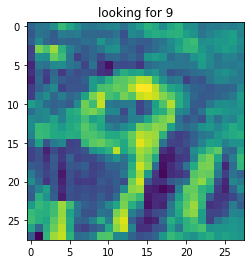

In [117]:
img, l, g = optimize_image_by_class(target_number, 100000)

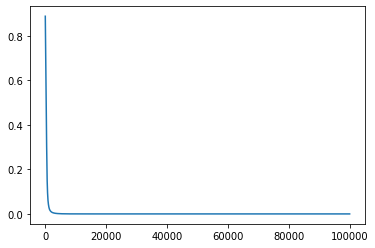

In [119]:
plt.plot(l)

Рисуем получившееся изображение, и ура, оно действительно похоже на 9ку!

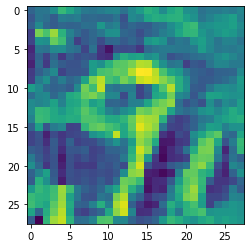

In [121]:
plt.imshow(img.detach().numpy().reshape(28, 28))

In [122]:
# получаем предсказание по этой картинке
activation = network(img.unsqueeze(0))

In [123]:
activation

tensor([[9.9899e-15, 6.0838e-10, 5.7372e-13, 6.2080e-09, 4.8616e-06, 2.7964e-07,
         3.1033e-15, 2.0912e-06, 2.2591e-07, 9.9999e-01]],
       grad_fn=<SoftmaxBackward>)

In [125]:
# оно равно 9
torch.argmax(activation[0])

tensor(9, grad_fn=<NotImplemented>)

Как видим, сеть научилась рисовать 9))